# Simulating more complex Non-Line-Of-Sight scenes

## Overview
<div class="admonition important alert alert-block alert-success">


🚀 **You will learn how to:**

<ul>
  <li>
  Simulate more complex NLOS scenes by loading Blender files into mitransient.

  <li>
  Use generic sensors to perform the transient scan, without the need to manually define a shape as the relay wall.
</ul>

</div>

In this tutorial, you will use mitransient to simulate more complex Non-Line-of-Sight (NLOS) captures.
As explained in the previous notebook, NLOS imaging algorithms allow us to reconstruct objects hidden from the
direct line-of-sigth. To simulate the capture process, we needed to manually define the hidden geometry,
the relay wall, the NLOS sensor and the emitter.


While defining these scenes as Mitsuba dictionaries can be straightforward for simple scenes,
it can also be cumbersome if we want to capture a more complicated scene, as we would need to
manually define each of its elements.
To avoid that, we will learn how to load Blender scenes for use with mitransient, allowing us to
easily edit our them and then perform the NLOS capture simulations once they are ready.

Previously, we used a `nlos-capture-meter` as our sensor, which limited the NLOS scan to the bounds of a
simple shape in the scene, such as a plane.
Being able to freely edit the scene with Blender allows us to place a conventional camera,
which will be used as the sensor, thus removing the need of manually specifying a certain shape in the
scene as the relay wall.

<div class="admonition important alert alert-block alert-warning">

To create these scenes, basic knowledge of Blender is required, mainly importing objects and moving them around the scene.

</div>

## Creating the scene

To begin with, we will start by recreating the simple scene from the previous notebook in Blender, which consisted of a single
2 by 2 meter plane used as a relay wall, a planar Z as our hidden geometry, the emitter and the camera,
both of which aim towards the center of the relay wall.

In this case, we will place the hidden Z, emitter and sensor further away from the relay wall.
As the camera and the emitter have the same exact position and orientation, we will only define
the camera in the Blender scene.

<div style="text-align: center;">
<img alt="Recreation of a simple NLOS scene in Blender" src="images/nlos-z-simple-preview.png" width="600">
</div>

We recommend starting with a simple version of your desired scene first, so you can trouble-shoot any problems in a constrained scenario.

Once the scene is ready, we can export it to a Mitsuba-compatible XML file, using the [Mitsuba Blender Add-on](https://github.com/mitsuba-renderer/mitsuba-blender)
(for instructions on installation and usage, please check [their wiki](https://github.com/mitsuba-renderer/mitsuba-blender/wiki)).
To be able to use the transient extensions provided by mitransient, we will need to manually modify the generated XML file.

First of all, we will modify the film of our sensor, to instead use the transient HDR film, allowing us to configure
the spatial and temporal resolution of our transient scan:

```xml
<film type="transient_hdr_film" name="film">
    <integer name="width" value="32"/>
    <integer name="height" value="32"/>
    <integer name="temporal_bins" value="300"/>
    <float name="bin_width_opl" value="0.006"/>
    <float name="start_opl" value="5.25"/>
    <rfilter type="box" name="rfilter"/>
</film>
```

Then, we need to modify the integrator used by the scene, defining the type of NLOS capture, as well as the sampling techniques used.

```xml
<integrator type="transient_nlos_path">
    <boolean name="nlos_laser_sampling" value="true"/>
    <boolean name="nlos_hidden_geometry_sampling" value="true"/>
    <boolean name="nlos_hidden_geometry_sampling_do_rroulette" value="false"/>
    <boolean name="nlos_hidden_geometry_sampling_includes_relay_wall" value="false"/>
    <boolean name="discard_direct_paths" value="False"/>
    <boolean name="account_first_and_last_bounces" value="False"/>
    <string name="temporal_filter" value="box"/>
    <integer name="capture_type" value="1"/> <!-- 1 == CaptureType.Single -->
</integrator>
```

Finally, as we did not define the emitter in the Blender scene, we will manually include it in the XML,
with the same world transform as the sensor, as their position and orientation is identical.

<div class="admonition important alert alert-block alert-warning">

If you want your emitter to be in a different location, or aim somewhere different to the sensor, we recommend
adding a spotlight in the Blender scene, and configuring it as desired before exporting.

</div>

```xml
<emitter type="projector">
    <rgb name="irradiance" value="100.0"/>
    <float name="fov" value="0.2"/>
    <!-- NOTE: this world transform is the same as the transform of the sensor-->
    <transform name="to_world">
        <rotate x="1" angle="180.00000500895632"/>
        <rotate y="1" angle="45.00000125223908"/>
        <rotate z="1" angle="180.00000500895632"/>
        <translate value="-2.000000 0.000000 2.000000"/>
    </transform>
</emitter>
```

By defining the scene this way, we avoid setting up a `nlos-capture-meter` in the scene and specifying one of the
shapes as the relay wall.
Instead, we use Blender to place and aim the camera however we want.

Once we have configured the XML scene file, we can load it and render the NLOS capture simulation.

In [1]:
# As usual, import mitsuba, set a variant and import mitransient
import mitsuba as mi
import drjit as dr
mi.set_variant('llvm_ad_mono')
import mitransient as mitr

In [2]:
# Load the scene from file
scene = mi.load_file('nlos-z-simple.xml')

In [3]:
# Render the scene
data_stedy, data_transient = mi.render(scene)

WARN: part of the sensor scan did not intersect the scene. Results for those scanned points should be ignored.


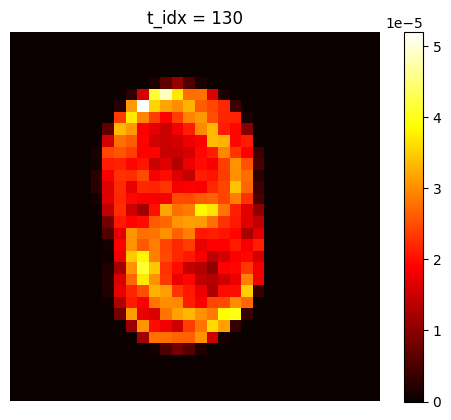

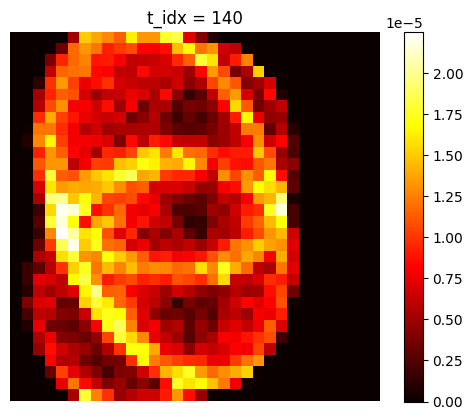

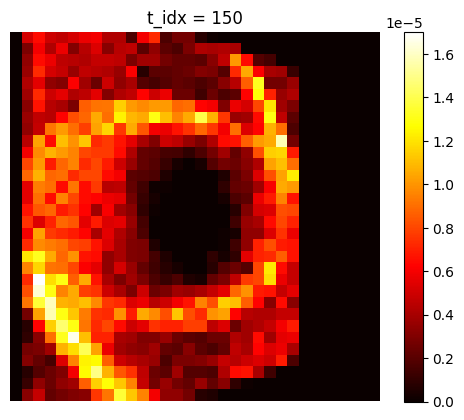

In [4]:
# Plot the simulated capture
import matplotlib.pyplot as plt
import numpy as np
def plot_time_instant(data, t):
    plt.imshow(np.array(data)[:, :, t, 0], cmap='hot')
    plt.colorbar()
    plt.axis('off')
    plt.xlabel('Relay wall X')
    plt.ylabel('Relay wall Y')
    plt.title(f't_idx = {t}')
    plt.show()

plot_time_instant(data_transient, 130)
plot_time_instant(data_transient, 140)
plot_time_instant(data_transient, 150)

As you can see, the camera we configured does not cover the relay wall completely, and the scan points are not spread uniformly,
as we are not using a `nlos-capture-meter` as sensor.
However, this removes the need of manually configuring a shape in the scene to be the relay wall,
allowing us to use any kind of geometry, which will be useful when we need to simulate
NLOS captures with more complicated scenes.

In [5]:
mitr.vis.show_video(data_transient, 2, normalize=True)

## Modifying the scene

Once we are sure we are correctly simulating the scene, we will start adding more details.
In this case, we use Blender to add walls and a floor, as well as an occluder plane that hides
the hidden geometry from the direct line-of-sight of the camera.
Note that we did not change the position of the camera and the hidden Z, so the configuration used
to simulate the simple version of the scene can be reused.

In this scene, there is no explicit shape marked as relay wall, instead the camera is positioned to
aim towards the part of the wall that we want to scan.

<div style="text-align: center;">
<img src="images/nlos-z-room-preview.png" width="600">
</div>

Once we are done modifying the scene using Blender, we export it to XML again and modify the required
fields to configure NLOS simulation, as we did with the previous version of the scene.

In [6]:
room_scene = mi.load_file('nlos-z-room.xml')

In [7]:
data_steady_room, data_transient_room = mi.render(room_scene)

WARN: part of the sensor scan did not intersect the scene. Results for those scanned points should be ignored.


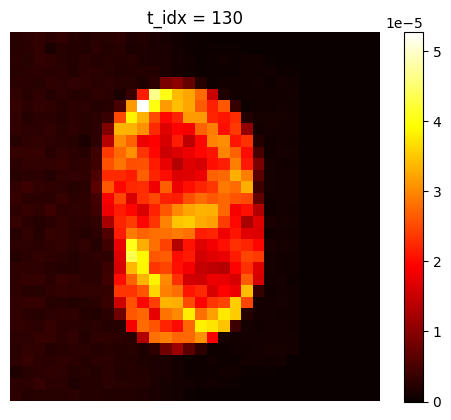

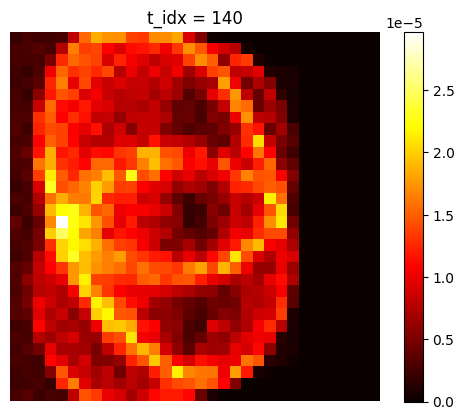

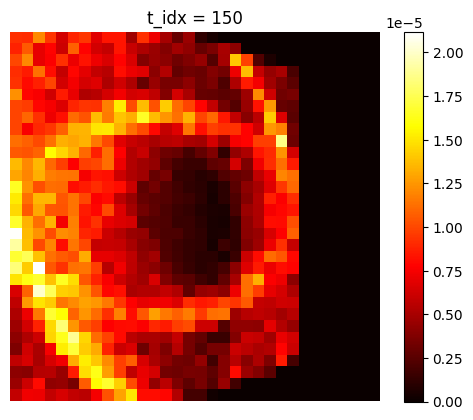

In [8]:
plot_time_instant(data_transient_room, 130)
plot_time_instant(data_transient_room, 140)
plot_time_instant(data_transient_room, 150)

Note that due to there being more geometry in the scene, there is signal in the relay surface before and after the pulses caused by the Z.
This is why we recommend to first render a simple version of the scene, so you know
beforehand the expected signal caused by the hidden geometry.

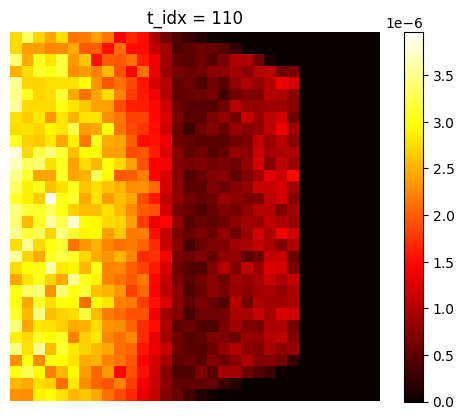

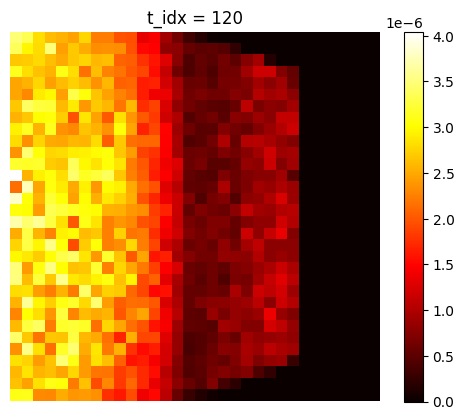

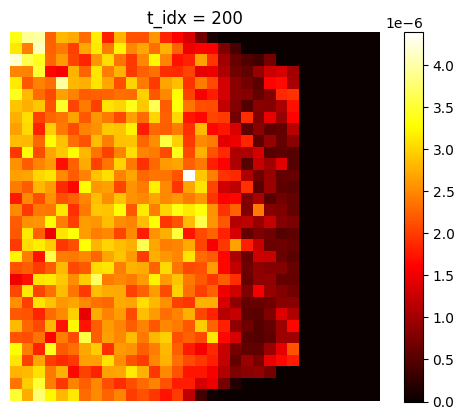

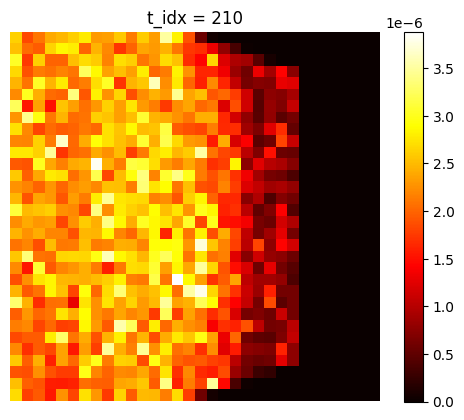

In [9]:
plot_time_instant(data_transient_room, 110)
plot_time_instant(data_transient_room, 120)
plot_time_instant(data_transient_room, 200)
plot_time_instant(data_transient_room, 210)

In [16]:
mitr.vis.show_video(data_transient_room, 2, normalize=True)

## Troubleshooting loaded scenes

Due to the nature of NLOS scenes, debugging the simulation of the capture process can be a
cumbersome process, as the recieved signal from the hidden geometry is usually low
and it can be impossible to detect if the scene is not configured properly.
We include some recommendations to ease troubleshooting:

- Always start with a simple scene, define only the sensor, emitter, hidden geometry and the geometry
    you want to use as relay wall. Once you are sure the simulation works as intended, start adding details
    to your scene.
- Use Mitsuba's Arbitrary Output Variable integrator. This integrator allows you to inspect different variables describing the
    visible geometry, such as depth or normals, which can be useful during debugging.
- Render the scene from another perspective, to inspect the imported geometry and make sure the scene
    has been loaded correctly.

In [11]:
# We create an AOV integrator and a new sensor to render the scenes AOVs
aov_integrator = mi.load_dict({
    'type': 'aov',
    'aovs': 'dd:depth, cc:prim_index, nn:sh_normal',
    'my_image': {
        'type': 'path',
    }
})
transient_sensor = scene.sensors()[0]
width = height = 500
sensor = mi.load_dict({
    'type': 'perspective',
    'fov': 40,
    'to_world': mi.ScalarTransform4f(transient_sensor.world_transform().matrix.to_numpy()[..., 0]),
    'film': {
        'type': 'hdrfilm',
        'width': width,
        'height': height
    }
})

2026-01-22 13:12:43 WARN  [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).


In [12]:
# Render the AOVs
aovs = mi.render(room_scene, integrator=aov_integrator, sensor=sensor)

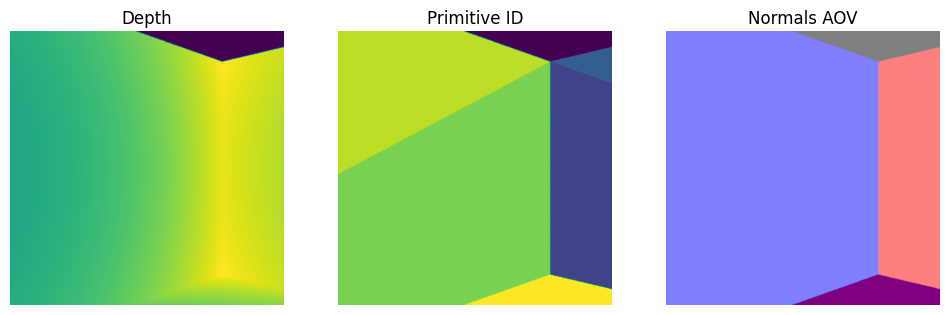

In [13]:
# Plot the AOVs of the visible geometry
def plot_aovs(aovs):
    depth = dr.reshape(mi.TensorXf, aovs[:, :, 1], (width, height, 1))
    mask = dr.reshape(mi.TensorXf, aovs[:, :, 2], (width, height, 1))
    normals = aovs[:, :, 3:]

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax[0].imshow(np.array(depth)); ax[0].axis('off'); ax[0].set_title('Depth')
    ax[1].imshow(np.array(mask)); ax[1].axis('off'); ax[1].set_title('Primitive ID')
    ax[2].imshow(np.array(normals) * 0.5 + 0.5); ax[2].axis('off'); ax[2].set_title('Normals AOV');
    plt.show()
plot_aovs(aovs)

In [14]:
# We can also modify the camera, to have a look at the scene we are trying to render from another angle.
sensor = mi.load_dict({
    'type': 'perspective',
    'fov': 40,
    'to_world': mi.ScalarTransform4f().look_at(
        origin=mi.ScalarPoint3f(-4, 2, 4),
        target=mi.ScalarPoint3f(0, 0, 0),
        up=mi.ScalarPoint3f(0, 1, 0)
    ),
    'film': {
        'type': 'hdrfilm',
        'width': width,
        'height': height
    }
})
aovs = mi.render(room_scene, integrator=aov_integrator, sensor=sensor)

2026-01-22 13:12:44 WARN  [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).


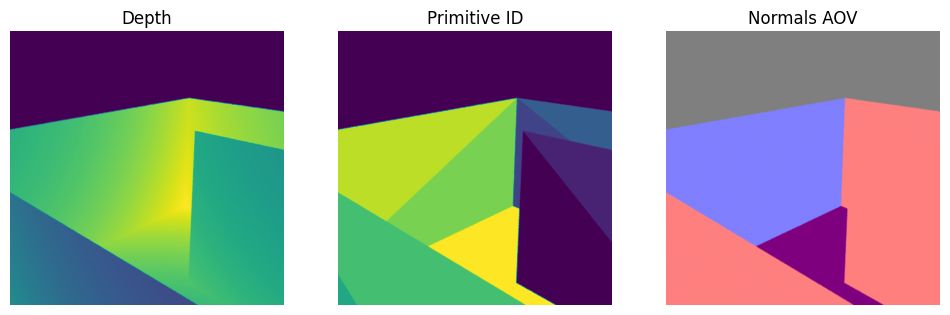

In [15]:
plot_aovs(aovs)

<div class="admonition important alert alert-block alert-success">

💡 For additional tools, check out `y-tal`, which has multiple NLOS reconstruction algorithms already implemented. [Click here to check `y-tal`.](https://github.com/diegoroyo/tal)

Note that some reconstruction algorithms such as Phasor Fields assume the relay wall to be a planar surface, so if you intend on using complex geometries as relay surface you may need a custom implementation to compute NLOS reconstructions.
</div>